In [4]:
file_path = "/Users/shrutijha/Desktop/A2_57/"
#file_path = "C:/Users/leifo/Downloads/nlp_assignment_2"

In [3]:
import numpy as np 
import json
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score, accuracy_score
from sklearn.preprocessing import LabelEncoder
from gensim.models import KeyedVectors

torch.manual_seed(1)

def load_data(file):
    with open(file, 'r') as file:
        data = json.load(file)
    sentences, labels = [], []
    for _, value in data.items():
        sentences.append(value['text'].split())
        labels.append(value['labels'])
    return sentences, labels

def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long)

def prepare_tags(tags, tag_to_ix):
    idxs = [tag_to_ix[t] for t in tags]
    return torch.tensor(idxs, dtype=torch.long)

def load_word2vec_embeddings(filepath):
    word_vectors = KeyedVectors.load_word2vec_format(filepath, binary=True)
    return word_vectors


def load_glove_embeddings(filepath):
    word_vectors = KeyedVectors.load_word2vec_format(filepath, binary=False)
    return word_vectors


def prepare_embedding_matrix_fasttext(fasttext_model, word_to_ix, embedding_dim=300):
    matrix_len = len(word_to_ix)
    weights_matrix = torch.zeros((matrix_len, embedding_dim))

    for word, i in word_to_ix.items():
        try: 
            weights_matrix[i] = torch.tensor(fasttext_model.wv[word])
        except KeyError:
            weights_matrix[i] = torch.randn((embedding_dim,))
    return weights_matrix

def prepare_embedding_matrix(word_vectors, word_to_ix, embedding_dim=300):
    matrix_len = len(word_to_ix)
    weights_matrix = torch.zeros((matrix_len, embedding_dim))

    for word, i in word_to_ix.items():
        try: 
            weights_matrix[i] = torch.from_numpy(word_vectors[word])
        except KeyError:
            weights_matrix[i] = torch.randn((embedding_dim,)) 

    return weights_matrix

def log_sum_exp(vec):
    max_score = vec[0, argmax(vec)]
    max_score_broadcast = max_score.view(1, -1).expand(1, vec.size()[1])
    return max_score + torch.log(torch.sum(torch.exp(vec - max_score_broadcast)))

def argmax(vec):
    _, idx = torch.max(vec, 1)
    return idx.item()

class BiLSTM_CRF(nn.Module):
    def __init__(self, vocab_size, tag_to_ix, embedding_dim, hidden_dim, embeddings):
        super(BiLSTM_CRF, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.tag_to_ix = tag_to_ix
        self.tagset_size = len(tag_to_ix)
        self.word_embeds = nn.Embedding.from_pretrained(embeddings, freeze=False)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim // 2, num_layers=1, bidirectional=True)
        self.hidden2tag = nn.Linear(hidden_dim, self.tagset_size)
        self.transitions = nn.Parameter(torch.randn(self.tagset_size, self.tagset_size))
        self.transitions.data[tag_to_ix[START_TAG], :] = -10000
        self.transitions.data[:, tag_to_ix[STOP_TAG]] = -10000

        self.hidden = self.init_hidden()

    def init_hidden(self):
        return (torch.randn(2, 1, self.hidden_dim // 2), torch.randn(2, 1, self.hidden_dim // 2))

    def _forward_alg(self, feats):

        init_alphas = torch.full((1, self.tagset_size), -10000.)
        init_alphas[0][self.tag_to_ix[START_TAG]] = 0.
        forward_var = init_alphas

        for feat in feats:
            alphas_t = []  
            for next_tag in range(self.tagset_size):
                
                emit_score = feat[next_tag].view(
                    1, -1).expand(1, self.tagset_size)
                trans_score = self.transitions[next_tag].view(1, -1)
                
                next_tag_var = forward_var + trans_score + emit_score
                
                alphas_t.append(log_sum_exp(next_tag_var).view(1))
            forward_var = torch.cat(alphas_t).view(1, -1)
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        alpha = log_sum_exp(terminal_var)
        return alpha

    def _get_lstm_features(self, sentence):
        self.hidden = self.init_hidden()
        embeds = self.word_embeds(sentence).view(len(sentence), 1, -1)
        lstm_out, self.hidden = self.lstm(embeds, self.hidden)
        lstm_out = lstm_out.view(len(sentence), self.hidden_dim)
        lstm_feats = self.hidden2tag(lstm_out)
        return lstm_feats

    def _score_sentence(self, feats, tags):
        score = torch.zeros(1)
        tags = torch.cat([torch.tensor([self.tag_to_ix[START_TAG]], dtype=torch.long), tags])
        for i, feat in enumerate(feats):
            score = score + \
                self.transitions[tags[i + 1], tags[i]] + feat[tags[i + 1]]
        score = score + self.transitions[self.tag_to_ix[STOP_TAG], tags[-1]]
        return score

    def _viterbi_decode(self, feats):
        backpointers = []
        init_vvars = torch.full((1, self.tagset_size), -10000.)
        init_vvars[0][self.tag_to_ix[START_TAG]] = 0

        forward_var = init_vvars
        for feat in feats:
            bptrs_t = []  
            viterbivars_t = []  

            for next_tag in range(self.tagset_size):
    
                next_tag_var = forward_var + self.transitions[next_tag]
                best_tag_id = argmax(next_tag_var)
                bptrs_t.append(best_tag_id)
                viterbivars_t.append(next_tag_var[0][best_tag_id].view(1))
        
            forward_var = (torch.cat(viterbivars_t) + feat).view(1, -1)
            backpointers.append(bptrs_t)

        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        best_tag_id = argmax(terminal_var)
        path_score = terminal_var[0][best_tag_id]

        best_path = [best_tag_id]
        for bptrs_t in reversed(backpointers):
            best_tag_id = bptrs_t[best_tag_id]
            best_path.append(best_tag_id)

        start = best_path.pop()
        assert start == self.tag_to_ix[START_TAG]  
        best_path.reverse()
        return path_score, best_path

    def neg_log_likelihood(self, sentence, tags):
        feats = self._get_lstm_features(sentence)
        forward_score = self._forward_alg(feats)
        gold_score = self._score_sentence(feats, tags)
        return forward_score - gold_score

    def forward(self, sentence): 
        lstm_feats = self._get_lstm_features(sentence)
        score, tag_seq = self._viterbi_decode(lstm_feats)
        return score, tag_seq

START_TAG = "<START>"
STOP_TAG = "<STOP>"
EMBEDDING_DIM = 300
HIDDEN_DIM = 64

train_sentences, train_labels = load_data('./NER_TRAIN.json')
val_sentences, val_labels = load_data('./NER_VAL.json')
test_sentences, test_labels = load_data('./NER_TEST.json')

word_to_ix = {}  
tag_to_ix = {'O': 0, 'B_CASE_NUMBER': 1, 'I_CASE_NUMBER': 2, 'B_ORG': 3, 'I_ORG': 4, 'B_OTHER_PERSON': 5, 'I_OTHER_PERSON': 6, 'B_STATUTE': 7, 'I_STATUTE': 8, 'B_PROVISION': 9, 'I_PROVISION': 10, 'B_COURT': 11, 'I_COURT': 12, 'B_WITNESS': 13, 'B_PRECEDENT': 14, 'I_PRECEDENT': 15, 'B_DATE': 16, 'B_PETITIONER': 17, 'I_PETITIONER': 18, 'I_WITNESS': 19, 'B_GPE': 20, 'B_RESPONDENT': 21, 'I_RESPONDENT': 22, 'I_DATE': 23, 'B_JUDGE': 24, 'I_JUDGE': 25, 'I_GPE': 26, START_TAG: 27, STOP_TAG: 28}
ix_to_tag = {0: 'O', 1: 'B_CASE_NUMBER', 2: 'I_CASE_NUMBER', 3: 'B_ORG', 4: 'I_ORG', 5: 'B_OTHER_PERSON', 6: 'I_OTHER_PERSON', 7: 'B_STATUTE', 8: 'I_STATUTE', 9: 'B_PROVISION', 10: 'I_PROVISION', 11: 'B_COURT', 12: 'I_COURT', 13: 'B_WITNESS', 14: 'B_PRECEDENT', 15: 'I_PRECEDENT', 16: 'B_DATE', 17: 'B_PETITIONER', 18: 'I_PETITIONER', 19: 'I_WITNESS', 20: 'B_GPE', 21: 'B_RESPONDENT', 22: 'I_RESPONDENT', 23: 'I_DATE', 24: 'B_JUDGE', 25: 'I_JUDGE', 26: 'I_GPE', 27: START_TAG, 28: STOP_TAG}

for sentence in train_sentences + val_sentences + test_sentences:
    for word in sentence:
        if word not in word_to_ix:
            word_to_ix[word] = len(word_to_ix)


from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit([tag for sublist in train_labels for tag in sublist])

LabelEncoder()

In [5]:
from gensim.scripts.glove2word2vec import glove2word2vec
glove_input_file = file_path + '/glove.6B.300d.txt'
word2vec_output_file = file_path + '/glove.6B.300d.word2vec.txt'

glove2word2vec(glove_input_file, word2vec_output_file)
word_vectors = load_glove_embeddings(word2vec_output_file)
embedding_matrix = prepare_embedding_matrix(word_vectors, word_to_ix)

C:\Users\leifo\AppData\Local\Temp\ipykernel_12668\3499400453.py:5: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_input_file, word2vec_output_file)
C:\Users\leifo\AppData\Local\Temp\ipykernel_12668\3015920881.py:60: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_numpy.cpp:212.)
  weights_matrix[i] = torch.from_numpy(word_vectors[word])


In [5]:
model = BiLSTM_CRF(len(word_to_ix), tag_to_ix, EMBEDDING_DIM, HIDDEN_DIM, embedding_matrix)
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)

train_losses = []
val_losses = []
train_f1_scores = []
val_f1_scores = []

def calculate_f1(data_sentences, data_labels):
    predictions, true_labels = [], []
    with torch.no_grad():
        for sentence, tags in zip(data_sentences, data_labels):
            sentence_in = prepare_sequence(sentence, word_to_ix)
            targets = prepare_tags(tags, tag_to_ix)
            loss = model.neg_log_likelihood(sentence_in, targets)
            _, output_tag_indices = model(sentence_in)

            output_tags = [ix_to_tag[ix] for ix in output_tag_indices if ix in ix_to_tag]
            predictions.extend(le.transform(output_tags))
            true_labels.extend(le.transform(tags))

    return f1_score(true_labels, predictions, average='macro'), loss.item()

# Training 
for epoch in range(5):  
    model.train()
    total_loss = 0
    for sentence, tags in zip(train_sentences, train_labels):
        model.zero_grad()
        sentence_in = prepare_sequence(sentence, word_to_ix)
        targets = prepare_tags(tags, tag_to_ix)

        loss = model.neg_log_likelihood(sentence_in, targets)
        
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    train_loss = total_loss / len(train_sentences)
    train_f1, _ = calculate_f1(train_sentences, train_labels)
    
    model.eval()
    val_f1, val_loss = calculate_f1(val_sentences, val_labels)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_f1_scores.append(train_f1)
    val_f1_scores.append(val_f1)

    print(f"Epoch {epoch}, Training Loss: {train_loss}, Training F1: {train_f1}, Validation Loss: {val_loss}, Validation F1: {val_f1}")

# # Loss Plot
# plt.figure(figsize=(10, 4))
# plt.plot(train_losses, label='Training Loss')
# plt.plot(val_losses, label='Validation Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.title('Training and Validation Loss')
# plt.legend()
# plt.show()

# # F1 Score Plot
# plt.figure(figsize=(10, 4))
# plt.plot(train_f1_scores, label='Training F1 Score')
# plt.plot(val_f1_scores, label='Validation F1 Score')
# plt.xlabel('Epochs')
# plt.ylabel('F1 Score')
# plt.title('Training and Validation F1 Score')
# plt.legend()
# plt.show()



# with torch.no_grad():
#     precheck_sent = prepare_sequence(train_sentences[0], word_to_ix)
#     precheck_tags = prepare_tags(train_labels[0], tag_to_ix)
#     print("PRECHECK")
#     print(model(precheck_sent))
#     print(precheck_tags)


# with torch.no_grad():
#     predictions = []
#     true_labels = []
#     for sentence, tags in zip(test_sentences, test_labels):
#         sentence_in = prepare_sequence(sentence, word_to_ix)
#         _, output_tag_indices = model(sentence_in)
#       
#         output_tags = [ix_to_tag[ix] for ix in output_tag_indices if ix in [0, 1, 2]]
#         predictions.extend(output_tags)
#         true_labels.extend(tags)

#     f1 = f1_score(le.transform(true_labels), le.transform(predictions), average='macro')
#     accuracy = accuracy_score(le.transform(true_labels), le.transform(predictions))
# print("f1_score: ",f1)
# print("accuracy: ",accuracy)

Epoch 0, Training Loss: 9.03741443304368, Training F1: 0.46432031025169485, Validation Loss: 2.08636474609375, Validation F1: 0.4037183876924288
Epoch 1, Training Loss: 4.808167438552272, Training F1: 0.5940033756733842, Validation Loss: 0.87030029296875, Validation F1: 0.46904501818559075
Epoch 2, Training Loss: 3.5246485643426086, Training F1: 0.7085789182205937, Validation Loss: 0.3563232421875, Validation F1: 0.5068390176879755
Epoch 3, Training Loss: 2.763328991799688, Training F1: 0.7807388470453097, Validation Loss: 0.23468017578125, Validation F1: 0.5166535548400032
Epoch 4, Training Loss: 2.1616923913409813, Training F1: 0.8384479022277425, Validation Loss: 0.24462890625, Validation F1: 0.538704693183932


NameError: name 'plt' is not defined

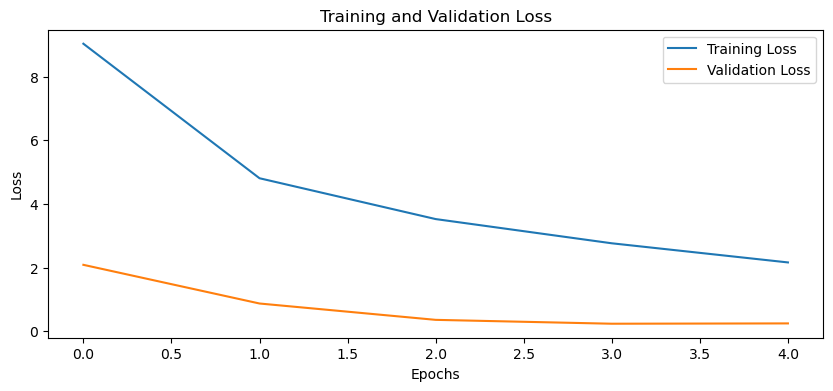

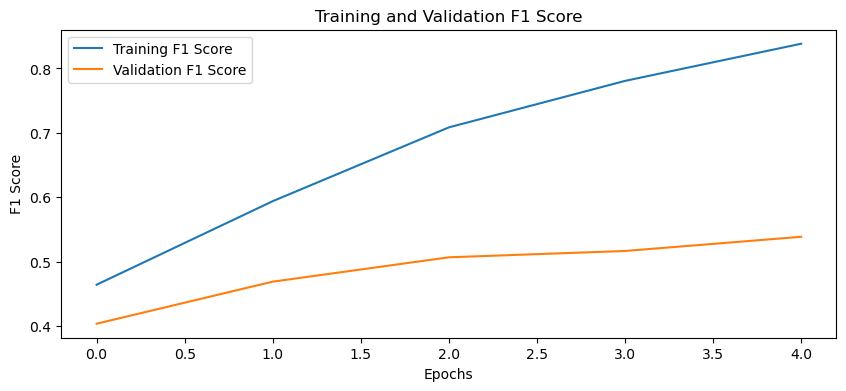

In [6]:
import matplotlib.pyplot as plt
# Loss Plot
plt.figure(figsize=(10, 4))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# F1 Score Plot
plt.figure(figsize=(10, 4))
plt.plot(train_f1_scores, label='Training F1 Score')
plt.plot(val_f1_scores, label='Validation F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.title('Training and Validation F1 Score')
plt.legend()
plt.show()

In [8]:
from sklearn.metrics import f1_score, accuracy_score

with torch.no_grad():
    precheck_sent = prepare_sequence(train_sentences[0], word_to_ix)
    precheck_tags = prepare_tags(train_labels[0], tag_to_ix)
    print("PRECHECK")
    print(model(precheck_sent))
    print(precheck_tags)


with torch.no_grad():
    predictions = []
    true_labels = []
    for sentence, tags in zip(test_sentences, test_labels):
        sentence_in = prepare_sequence(sentence, word_to_ix)
        _, output_tag_indices = model(sentence_in)
        
        output_tags = [ix_to_tag[ix] for ix in output_tag_indices]
        predictions.extend(output_tags)
        true_labels.extend(tags)

    f1 = f1_score(le.transform(true_labels), le.transform(predictions), average='macro')
    accuracy = accuracy_score(le.transform(true_labels), le.transform(predictions))
print("f1_score: ",f1)
print("accuracy: ",accuracy)

PRECHECK
(tensor(269.4034), [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
f1_score:  0.5082985746447897
accuracy:  0.91618332081142


In [10]:
torch.save(model.state_dict(), file_path + '/tk1_bilstm_crf_glove.pth')

In [8]:
from sklearn.metrics import f1_score, accuracy_score

model = BiLSTM_CRF(len(word_to_ix), tag_to_ix, EMBEDDING_DIM, HIDDEN_DIM, embedding_matrix)

model.load_state_dict(torch.load('./tk1_bilstm_crf_glove.pth'))

with torch.no_grad():
    predictions = []
    true_labels = []
    for sentence, tags in zip(test_sentences, test_labels):
        sentence_in = prepare_sequence(sentence, word_to_ix)
        _, output_tag_indices = model(sentence_in)
    
        output_tags = [ix_to_tag[ix] for ix in output_tag_indices]
        predictions.extend(output_tags)
        true_labels.extend(tags)

    f1 = f1_score(le.transform(true_labels), le.transform(predictions), average='macro')
    accuracy = accuracy_score(le.transform(true_labels), le.transform(predictions))
print("f1_score: ",f1)
print("accuracy: ",accuracy)

f1_score:  0.5334978650953721
accuracy:  0.9232757325319308
